# PCa Analysis Regarding PSA Levels in PCa Pts undergoing PT

In [15]:
import pandas as pd
import numpy as np 

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
#list(data.columns)
#list(data["MAX_PSA_PREPT_CUTOFF"].unique())

## Test for Normal Distribution and Homogeneity of Variance 

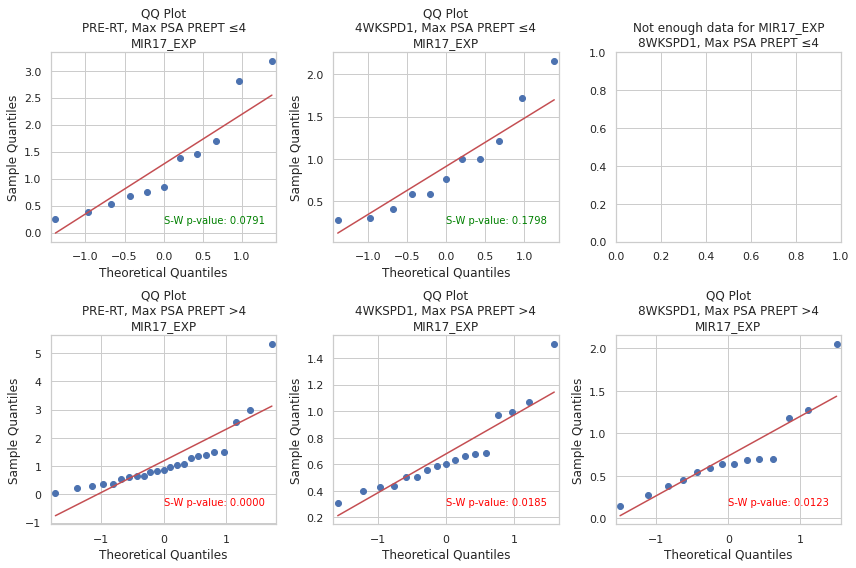

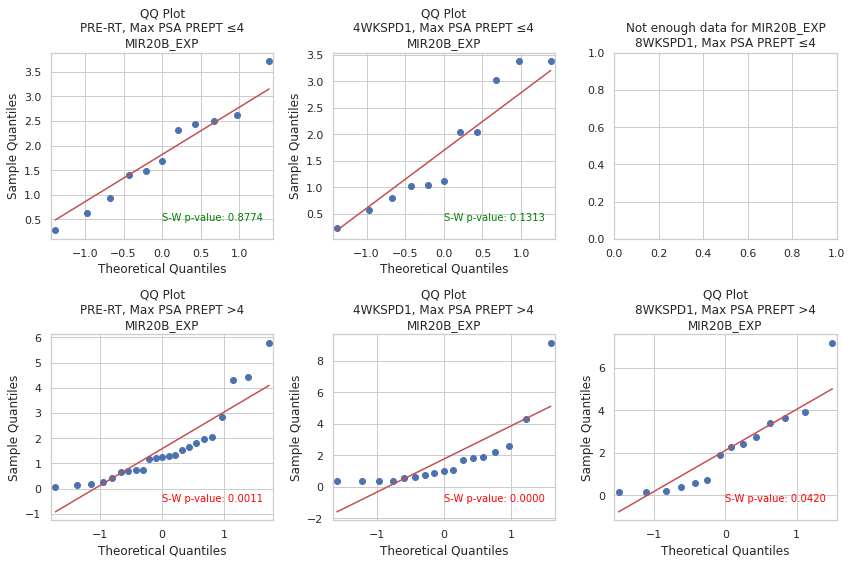

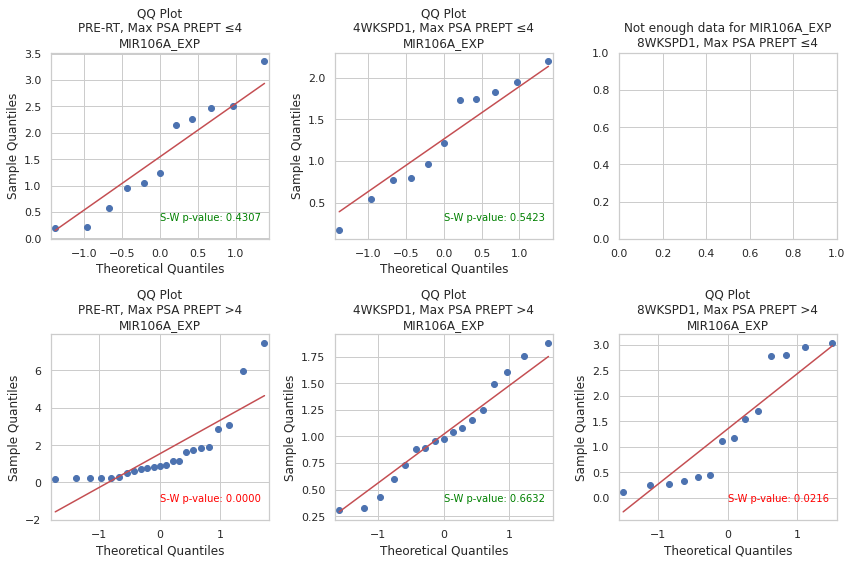

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

def analyze_gene(data, gene_name, hue_by, condition_order):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axes = axes.flatten()
    for idx, condition in enumerate(condition_order):
        ax = axes[idx]
        subset_data = data[data[hue_by] == condition]
        # Check if the subset data has at least 3 data points
        if len(subset_data[gene_name]) < 3:
            ax.set_title(f'Not enough data for {gene_name}\n{condition}')
            continue
        sm.qqplot(subset_data[gene_name], line='s', ax=ax)
        ax.set_title(f'QQ Plot\n{condition}\n{gene_name}')
        # Perform Shapiro-Wilk test
        shapiro_test_stat, shapiro_p_value = stats.shapiro(subset_data[gene_name])
        color = 'red' if shapiro_p_value < 0.05 else 'green'
        ax.text(0.5, 0.1, f'S-W p-value: {shapiro_p_value:.4f}', transform=ax.transAxes, fontsize=10, color=color)
    plt.tight_layout()
    plt.savefig(f'{gene_name}_QQPLOT.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()

# Specify the genes you want to analyze
genes_to_analyze = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']  # Add more genes as needed
#Specify the phenotype you want to analyze
hue_by = "MAX_PSA_PREPT_CUTOFF_CONDITION"
# Specify the order of sample conditions
condition_order = data["MAX_PSA_PREPT_CUTOFF_CONDITION"].unique()

# Call the function for each gene
for gene in genes_to_analyze:
    analyze_gene(data, gene, hue_by, condition_order)

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import levene

def run_levene_test(dataframe, gene_to_analyze, groups_column, timepoints_column):
    timepoints = np.unique(dataframe[timepoints_column])
    groups = np.unique(dataframe[groups_column])
    data_levene = []
    for tp in timepoints:
        for group in groups:
            subset = dataframe[(dataframe[timepoints_column] == tp) & (dataframe[groups_column] == group)][gene_to_analyze].values
            data_levene.append(subset)
    statistic, p_values = levene(*data_levene)
    print(f'Test Statistics: {round(statistic, 4)}')
    print(f'p-values: {round(p_values, 4)}')
    if p_values < 0.05:
        print('Variance between groups is HETEROGENEOUS')
    else:
        print('Variance between groups is HOMOGENEOUS')

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
mirnas = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]
feature = "MAX_PSA_PREPT_CUTOFF"

for mirna in mirnas:
    print(f'Levene Test for {mirna}')
    run_levene_test(dataframe = data, gene_to_analyze = mirna, groups_column = feature, timepoints_column = "TIME_POINT")
    if mirna != "MIR106A_EXP":
        print("\n")
        print("\n")

Levene Test for MIR17_EXP
Test Statistics: 1.5617
p-values: 0.1819
Variance between groups is HOMOGENEOUS




Levene Test for MIR20B_EXP
Test Statistics: 0.65
p-values: 0.6624
Variance between groups is HOMOGENEOUS




Levene Test for MIR106A_EXP
Test Statistics: 1.4248
p-values: 0.2257
Variance between groups is HOMOGENEOUS


## Descriptive Statistics on miRNA Expression levels Regarding PSA Levels

In [10]:
# Load the data
import pandas as pd
import numpy as np 
from datetime import datetime

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
current_date = datetime.now().strftime('%Y_%m_%d')
column = "MAX_PSA_PREPT_CUTOFF"

# Perform descriptive statistics on the data frame
miRNA_exp_descr_stats = data.groupby(['TIME_POINT', column], sort=False)[['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']].describe()
# Round the values to a specific number of decimals
miRNA_exp_descr_stats = miRNA_exp_descr_stats.round(decimals=3)
# Reset index to make the DataFrame more readable in the output
miRNA_exp_descr_stats.reset_index(inplace=True)
outputfile_name = f'{current_date}_{column}_DESCRIPTIVE_STATS.xlsx'
# Save the result to a CSV file
miRNA_exp_descr_stats.to_excel(outputfile_name, index=True)
### Download and format in excel independently

## Manual Programming of Mann-Whitney U Test 

In [11]:
import pandas as pd
import numpy as np 
from scipy.stats import mannwhitneyu

# Import the Data
path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)

genes = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]
timepoints = ["PRE-RT", "4WKSPD1", "8WKSPD1"]
column1 = "TIME_POINT"
column2 = "MAX_PSA_PREPT_CUTOFF"
groups = data[column2].unique()

# Subset the data for Mann-Whitney U Testing
tuple_mir17 = []
tuple_mir20b = []
tuple_mir106a = []
        
for gene in genes:    
    for tp in timepoints:
        subset1 = data[(data[column1] == f'{tp}') & (data[column2] == f'{groups[0]}')][gene].values
        subset2 = data[(data[column1] == f'{tp}') & (data[column2] == f'{groups[1]}')][gene].values
        mypair = (subset1, subset2)
        if gene == "MIR17_EXP":
            tuple_mir17.append(mypair)
        elif gene == "MIR20B_EXP":
            tuple_mir20b.append(mypair)
        else:
            tuple_mir106a.append(mypair)

### Accessing the Tuple
# tuple_miRNA[0-2], provides the timepoints, 0=prert, 1=4wkspd1, 2=8wkspd1
# tuple_miRNA[0-2][0-1], provides the group [0='≤T2b', 1='>T2b']

# Perform the Mann-Whitney U Test:
for miRNA in genes:
    print(f'Mann-Whitney U Test for {miRNA}')
    if miRNA == "MIR17_EXP":
        for idx, (group1_data, group2_data) in enumerate(tuple_mir17, start = 1):
            if idx == 1:
                print(f'Comparison at PRE-PT')
            elif idx == 2:
                print(f'Comparison at 4WKSPD1')
            else: 
                print(f'Comparison at 8WKSPD1')
            mannwhit_stat, p_value = mannwhitneyu(group1_data, group2_data, alternative = "two-sided")
            print(f"Mann-Whitney U Statistic: {mannwhit_stat:.3f}")
            print(f"P-value: {p_value:.3f}")
            if p_value < 0.05:
                print(f'Gene Expression is DIFFERENT')
            else:
                print(f'Gene Expression is NOT different')
            print("\n")
        print("\n"*3)
    elif miRNA == "MIR20B_EXP":
        for idx, (group1_data, group2_data) in enumerate(tuple_mir20b, start = 1):
            if idx == 1:
                print(f'Comparison at PRE-PT')
            elif idx == 2:
                print(f'Comparison at 4WKSPD1')
            else: 
                print(f'Comparison at 8WKSPD1')
            mannwhit_stat, p_value = mannwhitneyu(group1_data, group2_data, alternative = "two-sided")
            print(f"Mann-Whitney U Statistic: {mannwhit_stat:.3f}")
            print(f"P-value: {p_value:.3f}")
            if p_value < 0.05:
                print(f'Gene Expression is DIFFERENT')
            else:
                print(f'Gene Expression is NOT different')
            print("\n")
        print("\n"*3)
    else:
        for idx, (group1_data, group2_data) in enumerate(tuple_mir106a, start = 1):
            if idx == 1:
                print(f'Comparison at PRE-PT')
            elif idx == 2:
                print(f'Comparison at 4WKSPD1')
            else: 
                print(f'Comparison at 8WKSPD1')
            mannwhit_stat, p_value = mannwhitneyu(group1_data, group2_data, alternative = "two-sided")
            print(f"Mann-Whitney U Statistic: {mannwhit_stat:.3f}")
            print(f"P-value: {p_value:.3f}")
            if p_value < 0.05:
                print(f'Gene Expression is DIFFERENT')
            else:
                print(f'Gene Expression is NOT different')
            print("\n")

Mann-Whitney U Test for MIR17_EXP
Comparison at PRE-PT
Mann-Whitney U Statistic: 139.000
P-value: 0.659
Gene Expression is NOT different


Comparison at 4WKSPD1
Mann-Whitney U Statistic: 111.500
P-value: 0.410
Gene Expression is NOT different


Comparison at 8WKSPD1
Mann-Whitney U Statistic: 18.000
P-value: 0.600
Gene Expression is NOT different






Mann-Whitney U Test for MIR20B_EXP
Comparison at PRE-PT
Mann-Whitney U Statistic: 158.000
P-value: 0.254
Gene Expression is NOT different


Comparison at 4WKSPD1
Mann-Whitney U Statistic: 110.000
P-value: 0.452
Gene Expression is NOT different


Comparison at 8WKSPD1
Mann-Whitney U Statistic: 19.000
P-value: 0.500
Gene Expression is NOT different






Mann-Whitney U Test for MIR106A_EXP
Comparison at PRE-PT
Mann-Whitney U Statistic: 149.000
P-value: 0.418
Gene Expression is NOT different


Comparison at 4WKSPD1
Mann-Whitney U Statistic: 113.000
P-value: 0.371
Gene Expression is NOT different


Comparison at 8WKSPD1
Mann-Whitney U Statist

## Plot on PSA Levels with Mann-Whitney U Test Result Annotations

In [16]:
# Import Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from statannotations.Annotator import Annotator

# Define function to plot Mann-Whitney U Test Plots
def plot_gene(x, data, hue, gene_name, ax, hue_order, custom_palette, PROPS, flierprops, stat_pairs):
    feature = "MAX_PSA_PREPT_CUTOFF"
    pheno = data[feature].unique()
    #['≤4', '>4']
    sns.set(style="whitegrid")
    # Plot Boxplot
    sns.boxplot(x=x, y=gene_name, data=data, order=["PRE-RT", "4WKSPD1", "8WKSPD1"], hue=hue, hue_order=hue_order,
                palette=custom_palette, showmeans=False, showfliers=False,
                meanprops={"marker": "s", "markerfacecolor": "black", "markersize": 5, "markeredgecolor": "black"},
                linewidth=1.5, medianprops=dict(color="black"), flierprops=flierprops, **PROPS, ax=ax)

    # Get the legend from just the box plot
    handles, labels = ax.get_legend_handles_labels()

    sns.swarmplot(x=x, y=gene_name, data=data, order=["PRE-RT", "4WKSPD1", "8WKSPD1"], hue=hue, hue_order=hue_order,
                  palette=custom_palette, dodge=True, size=5, linewidth=0.5, edgecolor="black", ax=ax)

    # Add Annotations
    annotator = Annotator(ax=ax, pairs=stat_pairs, data=data, x=x, y=gene_name, order=["PRE-RT", "4WKSPD1", "8WKSPD1"],
                          hue=hue, hue_order=hue_order, palette=custom_palette)
    
    annotator.configure(test="Mann-Whitney", verbose = False).apply_and_annotate() # comparisons_correction="Bonferroni"

    # Remove the old legend
    ax.legend_.remove()

    # Add just the handles/labels from the box plot back
    legend = ax.legend(handles, labels, loc=0)
    legend.set_title("PCa PSA Range:", prop={"size": 9, "family": "serif"})
    for text in legend.texts:
        text.set_fontsize(9)  # Set the desired font size
        text.set_family("serif")  # Set the desired font family

    # Map and update the labels to new ones
    new_labels = {pheno[0]: "≤4", pheno[1]: ">4"}
    for text, handle in zip(legend.texts, legend.legendHandles):
        text.set_text(new_labels[text.get_text()])

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'PRE-PT'
    labels[1] = '4WKSPD1'
    labels[2] = '8WKSPD1'
    ax.set_xticklabels(labels, family="serif")
    ax.set_yticklabels(ax.get_yticklabels(), family="serif")

    ax.xaxis.tick_top()
    ax.xaxis.tick_bottom()
    ax.tick_params(axis='x', labelsize=9, labelrotation=0)
    ax.tick_params(axis='y', labelsize=9)

    ax.set_xlabel('Time Point', family="serif", fontsize=12)
    ax.set_ylabel('Gene Expression Fold Change', family="serif", fontsize=12)
    variable = gene_name
    result = variable.split('_')[0]
    ax.set_title(result, family="serif")
    

In [17]:
# Call the function to perform the plots 
# Load the data
path = "/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx"
data = pd.read_excel(path)

pheno = data[feature].unique()
#['≤4', '>4']

# Define the Pairs needed for the plot annotations with STATANNOTATOR
mannwhitu_testpairs = [[("PRE-RT",pheno[0]), ("PRE-RT", pheno[1])],
                       [("4WKSPD1",pheno[0]), ("4WKSPD1", pheno[1])],
                       [("8WKSPD1", pheno[0]), ("8WKSPD1", pheno[1])]]

# Call Plotting Parameters
column1 = "TIME_POINT"
column2 = "MAX_PSA_PREPT_CUTOFF"
group_hue_order = [pheno[0], pheno[1]]
group_custom_palette = {pheno[0] : "#E8E8E8", pheno[1]: "#505050"}
group_PROPS = {'boxprops': {'edgecolor': 'black'}, 'whiskerprops': {'color': 'black'}, 'capprops': {'color': 'black'}}
group_flierprops = dict(markerfacecolor='grey', markersize=5, markeredgecolor='black')

# Begin Plotting
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 8), dpi=600)
# Call the function for each gene
genes_to_plot = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']  # Add more genes as needed
for idx, gene in enumerate(genes_to_plot):
    plot_gene(x=column1, data=data, gene_name=gene, ax=axs[idx], hue = column2, hue_order=group_hue_order,
              custom_palette=group_custom_palette, PROPS=group_PROPS, flierprops = group_flierprops, 
              stat_pairs=mannwhitu_testpairs)

# Save individual gene plots
for idx, gene in enumerate(genes_to_plot):
    extent = axs[idx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    variable = gene
    gene_name = variable.split('_')[0]
    fig.savefig(f'{column2}_{gene_name}_subplot.png', format='png', dpi=600, bbox_inches=extent.expanded(1.18, 1.2))

# Save combined plot
plt.savefig(f'{column2}_plot.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

/scratch/local/18029188/ipykernel_505686/1871725998.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for text, handle in zip(legend.texts, legend.legendHandles):
/scratch/local/18029188/ipykernel_505686/1871725998.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")
/scratch/local/18029188/ipykernel_505686/1871725998.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for text, handle in zip(legend.texts, legend.legendHandles):
/scratch/local/18029188/ipykernel_505686/1871725998.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLo

## Group 1 Plot with Kruskal Wallis Test Result Annotations

In [1]:
import pandas as pd 
path = "/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx"
data = pd.read_excel(path)

column = "MAX_PSA_PREPT_CUTOFF"
group = data[column].unique()
#['≤4', '>4']
# Check group[0] is the lower group one, otherwise change to group[1]


# Import Libraries
import pandas as pd
import numpy as np 
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Define the plot for Kruskal Wallis Annotations to Group 1
def plot_gene_group(data, gene_name, ax, group_num):
    # Subset data
    column1 = "TIME_POINT"
    column2 = "MAX_PSA_PREPT_CUTOFF"
    group = data[column2].unique()
    if group_num == 1:
        group_analysis = data[data[column2] == group[0]]
        custom_palette = {"PRE-RT": "#E8E8E8", "4WKSPD1": "#E8E8E8", "8WKSPD1": "#E8E8E8"}
    elif group_num == 2:
        group_analysis = data[data[column2] == group[1]]
        custom_palette = {"PRE-RT": "#505050", "4WKSPD1": "#505050", "8WKSPD1": "#505050"}
    
    PROPS = {'boxprops': {'edgecolor': 'black'}, 'whiskerprops': {'color': 'black'}, 'capprops': {'color': 'black'}}
    flierprops = dict(markerfacecolor='grey', markersize=5, markeredgecolor='black')
    tp_order = ["PRE-RT", "4WKSPD1", "8WKSPD1"]
    
    # Define Kruskal Wallis Test pairs
    tps = list(["PRE-RT", "4WKSPD1", "8WKSPD1"])
    tp_pairs = list(combinations(tps, r=2))
    
    # Start Plotting
    sns.set(style="whitegrid")
    
    sns.boxplot(x=column1, y=gene_name, data=group_analysis, order=tp_order, palette=custom_palette, showmeans=False,
                showfliers=False, meanprops={"marker": "s", "markerfacecolor": "black", "markersize": 5, "markeredgecolor": "black"},
                linewidth=1.5, medianprops=dict(color="black"), flierprops=flierprops, **PROPS, ax=ax)

    sns.swarmplot(x=column1, y=gene_name, data=group_analysis, order=tp_order, palette=custom_palette, dodge=True,
                  size=5, linewidth=0.5, edgecolor="black", ax=ax)

    annotator = Annotator(ax=ax, pairs=tp_pairs, data=group_analysis, x=column1, y=gene_name, order=tp_order, palette=custom_palette)
    annotator.configure(test='Kruskal', verbose = False).apply_and_annotate() #comparisons_correction="Holm-Bonferroni"

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'PRE-PT'
    labels[1] = '4WKSPD1'
    labels[2] = '8WKSPD1'
    ax.set_xticklabels(labels, family="serif")
    ax.set_yticklabels(ax.get_yticklabels(), family="serif")

    ax.xaxis.tick_top()
    ax.xaxis.tick_bottom()
    ax.tick_params(axis='x', labelsize=9, labelrotation=0)
    ax.tick_params(axis='y', labelsize=9)

    ax.set_xlabel('Time Point', family="serif", fontsize=12)
    ax.set_ylabel('Gene Expression Fold Change', family="serif", fontsize=12)
    variable = gene_name
    result = variable.split('_')[0]
    ax.set_title(result, family="serif")


In [19]:
# Load the data
path = "/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx"
data = pd.read_excel(path)

# Begin Plotting
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 8), dpi=600)
# Call the function for each gene
genes_to_plot = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']  # Add more genes as needed
for idx, gene in enumerate(genes_to_plot):
    plot_gene_group(data=data, gene_name=gene, ax=axs[idx], group_num=1)

# Save individual gene plots
name_phenotype = "PSALEVEL"

for idx, gene in enumerate(genes_to_plot):
    extent = axs[idx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    variable = gene
    gene_name = variable.split('_')[0]
    fig.savefig(f'Less_{name_phenotype}_{gene_name}_subplot.png', format='png', dpi=600, bbox_inches=extent.expanded(1.18, 1.2))

# Save combined plot
plt.savefig(f'Less_{name_phenotype}_plot.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


/scratch/local/18029188/ipykernel_505686/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")
/scratch/local/18029188/ipykernel_505686/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")
/scratch/local/18029188/ipykernel_505686/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")


## Group 2 Plot with Kruskal Wallis Test Result Annotations

In [2]:
# Load the data
path = "/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx"
data = pd.read_excel(path)

sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 8), dpi=600)
# Call the function for each gene
genes_to_plot = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']  # Add more genes as needed
for idx, gene in enumerate(genes_to_plot):
    plot_gene_group(data=data, gene_name=gene, ax=axs[idx], group_num=2)

# Save individual gene plots
name_phenotype = "PSALEVEL"
for idx, gene in enumerate(genes_to_plot):
    extent = axs[idx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    variable = gene
    gene_name = variable.split('_')[0]
    fig.savefig(f'Greater_{name_phenotype}_{gene_name}_subplot.png', format='png', dpi=600, bbox_inches=extent.expanded(1.18, 1.2))

# Save combined plot
plt.savefig(f'Greater_{name_phenotype}_plot.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

/scratch/local/18029188/ipykernel_567466/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")
/scratch/local/18029188/ipykernel_567466/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")
/scratch/local/18029188/ipykernel_567466/2541931677.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), family="serif")


## Manual Programming of the Kruskal Wallis Test 

In [3]:
import pandas as pd
import numpy as np 
from scipy import stats 
from scikit_posthocs import posthoc_dunn 

# Define Kruskal Wallis Test 
def run_kruskal_group1(dataframe, miRNA_col, group_column, tp_col):
    groups = data[group_column].unique()
    group1_subset = data[data[group_column] == groups[0]]
    tp = np.unique(data[tp_col])
    subset_data = [group1_subset[group1_subset[tp_col] == t][miRNA_col] for t in tp]
    kruskwall, p_value = stats.kruskal(*subset_data)
    print(f"Kruskal-Wallis Test Result for {miRNA_col} {groups[0]}")
    print(f'Test Statistic: {round(kruskwall, 4)}')
    print(f'p-value: {round(p_value, 4)}')
    dunn_df = posthoc_dunn(group1_subset, val_col=miRNA_col, group_col=tp_col)
    print(f"Dunn's Test Result for {miRNA_col}, Group: {groups[0]}")
    print(f'{round(dunn_df, 4)}')


# Import the Data
data = pd.read_excel("/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx")

column1 = "TIME_POINT"
column2 = "MAX_PSA_PREPT_CUTOFF"
genes = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]

for miRNA in genes:
    run_kruskal_group1(dataframe=data, miRNA_col=miRNA, group_column=column2, tp_col=column1)
    print("\n")

Kruskal-Wallis Test Result for MIR17_EXP ≤4
Test Statistic: 0.4009
p-value: 0.8184
Dunn's Test Result for MIR17_EXP, Group: ≤4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.8606  0.5266
8WKSPD1   0.8606   1.0000  0.8606
PRE-RT    0.5266   0.8606  1.0000


Kruskal-Wallis Test Result for MIR20B_EXP ≤4
Test Statistic: 1.7245
p-value: 0.4222
Dunn's Test Result for MIR20B_EXP, Group: ≤4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.1892  0.6951
8WKSPD1   0.1892   1.0000  0.2733
PRE-RT    0.6951   0.2733  1.0000


Kruskal-Wallis Test Result for MIR106A_EXP ≤4
Test Statistic: 0.5941
p-value: 0.743
Dunn's Test Result for MIR106A_EXP, Group: ≤4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.8704  0.4419
8WKSPD1   0.8704   1.0000  0.7922
PRE-RT    0.4419   0.7922  1.0000




In [4]:
import pandas as pd
import numpy as np 
from scipy import stats 
from scikit_posthocs import posthoc_dunn 

# Define Kruskal Wallis Test 
def run_kruskal_group2(dataframe, miRNA_col, group_column, tp_col):
    groups = data[group_column].unique()
    group2_subset = data[data[group_column] == groups[1]]
    tp = np.unique(data[tp_col])
    subset_data = [group2_subset[group2_subset[tp_col] == t][miRNA_col] for t in tp]
    kruskwall, p_value = stats.kruskal(*subset_data)
    print(f"Kruskal-Wallis Test Result for {miRNA_col} {groups[1]}")
    print(f'Test Statistic: {round(kruskwall, 4)}')
    print(f'p-value: {round(p_value, 4)}')
    dunn_df = posthoc_dunn(group2_subset, val_col=miRNA_col, group_col=tp_col)
    print(f"Dunn's Test Result for {miRNA_col}, Group: {groups[1]}")
    print(f'{round(dunn_df, 4)}')


# Import the Data
data = pd.read_excel("/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx")

column1 = "TIME_POINT"
column2 = "MAX_PSA_PREPT_CUTOFF"
genes = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]

for miRNA in genes:
    run_kruskal_group2(dataframe=data, miRNA_col=miRNA, group_column=column2, tp_col=column1)
    print("\n")

Kruskal-Wallis Test Result for MIR17_EXP >4
Test Statistic: 3.1894
p-value: 0.203
Dunn's Test Result for MIR17_EXP, Group: >4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.8483  0.1041
8WKSPD1   0.8483   1.0000  0.1836
PRE-RT    0.1041   0.1836  1.0000


Kruskal-Wallis Test Result for MIR20B_EXP >4
Test Statistic: 0.4293
p-value: 0.8068
Dunn's Test Result for MIR20B_EXP, Group: >4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.5509  0.9437
8WKSPD1   0.5509   1.0000  0.5698
PRE-RT    0.9437   0.5698  1.0000


Kruskal-Wallis Test Result for MIR106A_EXP >4
Test Statistic: 0.0582
p-value: 0.9713
Dunn's Test Result for MIR106A_EXP, Group: >4
         4WKSPD1  8WKSPD1  PRE-RT
4WKSPD1   1.0000   0.8940  0.9162
8WKSPD1   0.8940   1.0000  0.8095
PRE-RT    0.9162   0.8095  1.0000


